# Single Resistor, Pulse During Discharge
About as easy as we can get for emulating a battery: $V=IR$

Let's make the voltage a linear function of the state of charge, $V(SOC) = 2 + SOC$, and assume the battery has a 1 A-hr capacity (C).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from battdat.data import BatteryDataset
import pandas as pd
import numpy as np

## Assume a Constant Current Charge, with a Pulse in the Midle
As [before](./resistor-only_simple-cycling.ipynb), we are going to assume a SOC at $t=0$ of 0.
Now, we will make the charge piecewise linear:

\begin{equation}
I(t) = \left\{ \begin{array}{lr}
   I_0 & t \le 1800 \\
   -2I_0 & 1800 < t \le 1900 \\
   2I_0 & 1900 < t \le 2000 \\
   I_0 & 2000 < t \le 3800 
\end{array} \right\}
\end{equation}

The battery is full charged at $t = 3800$, then we discharge at a constant rate of $-I_0$


In [2]:
I_0 = 1  # Amp
C = 3600 # Amp-s
R = 0.1 # Ohm

Specify the charge protocol

In [3]:
data = pd.DataFrame({'time': np.arange(0, 7401, 2, dtype=float)})
data['current'] = np.nan

In [4]:
data.loc[data.time <= 3800, 'current'] = I_0
data.loc[data.time <= 2000, 'current'] = 2 * I_0  # Overwriting values, because it's easier tha setting up 
data.loc[data.time <= 1900, 'current'] = -2 * I_0
data.loc[data.time <= 1800, 'current'] = I_0
data.loc[data.time > 3800, 'current'] = -I_0

Compute the SOC

In [5]:
data['SOC'] = np.nan
data.loc[data.time <= 3800, 'SOC'] = (data['time'] - 200) / 3600  # Increase 1A from full charge
data.loc[data.time <= 2000, 'SOC'] = 0.5 - 2 * 100 / 3600 + 2 * (data['time'] - 1900) / 3600  # Increase 1A from full charge
data.loc[data.time <= 1900, 'SOC'] = 0.5 - 2 * (data['time'] - 1800) / 3600  # Increase 1A from full charge
data.loc[data.time <= 1800, 'SOC'] = data['time'] / 3600
data.loc[data.time > 3800, 'SOC'] = 1 - (data['time'] - 3800) / 3600

Compute the voltage

$V(t) = SOC(t) + I(t) * 4$

In [6]:
data['voltage'] = 2 + data['SOC'] + data['current'] * R

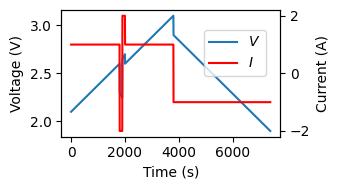

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(data['time'], data['voltage'], label='$V$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

ax2 = ax.twinx()
ax2.plot(data['time'], data['current'], color='red', label='$I$')
ax2.set_ylabel('Current (A)')

fig.legend(loc=(0.6, 0.6))
fig.tight_layout()

## Save in HDF5 Format
So we can load it in easily later

In [8]:
raw_data = pd.DataFrame({
    'test_time': data['time'],
    'current': data['current'],
    'voltage': data['voltage'],
    'cycle_number': np.zeros_like(data['time'], dtype=int),
})

In [9]:
data = BatteryDataset.make_cell_dataset(raw_data=raw_data)
data.validate()

[]

In [10]:
data.to_hdf('single-resistor-complex-charge_from-discharged.hdf', complevel=9)
data.to_parquet('single-resistor-complex-charge_from-discharged')

{'raw_data': PosixPath('single-resistor-complex-charge_from-discharged/raw_data.parquet')}